<div align="center">

# MEGR7172/8172

### Computational Methods (Fall 2025)
### Duke 227, Tu/Th 08:30 - 09:45 pm

</div>


# 13 The Quasi-Newton Method


In the previous course, we explored gradient descent and briefly introduced conjugate gradient methods for optimization. These approaches rely on first-order gradient information to determine the direction of each step. However, one might wonder if incorporating second-order information—such as curvature—could further improve convergence. This leads us to Newton's method, which uses the Hessian matrix (second derivatives), and subsequently to Quasi-Newton methods.

Quasi-Newton methods are a class of optimization algorithms designed to find local minima of functions efficiently. Unlike classical Newton's method, which requires explicit computation of the Hessian matrix, Quasi-Newton methods iteratively build an approximation of the Hessian using only gradient information. This makes them especially practical and efficient for large-scale problems where calculating the full Hessian is computationally expensive or infeasible. Among these, the BFGS algorithm is particularly popular due to its robustness and effectiveness in unconstrained optimization tasks commonly encountered in scientific computing and machine learning.

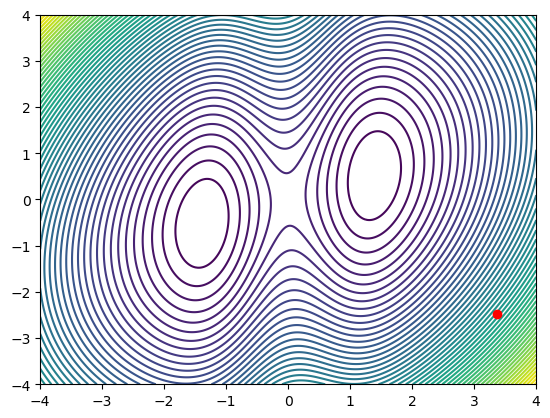

In [3]:
import numpy as np
import matplotlib.pyplot as plt

def f1(x): #simple function with 1 minimum
    return x[0]**2/2 + x[1]**2/3 - x[0]*x[1]/4 # + 3* np.exp(-x[0]**2)

def f2(x): #complex function with 2 minimum
    return x[0]**2/2 + x[1]**2/3 - x[0]*x[1]/4 + 3* np.exp(-x[0]**2)
    #return (1-x[0])**2 + 100*(x[1]-x[0]**2)**2

def init(x_min, x_max, y_min, y_max):
    x0 = x_min+np.random.random()*(x_max-x_min)
    y0 = y_min+np.random.random()*(y_max-y_min)
    return [x0, y0]

x_min, x_max = -4, 4
y_min, y_max = -4, 4                   

nx = np.linspace(x_min,x_max,400)
ny = np.linspace(y_min,y_max,400)

x,y = np.meshgrid(nx,ny)
z = f2([x, y])
fig = plt.figure()
levels = np.arange(np.min(z), np.max(z), 0.3)
plt.contour(x,y,z, levels=levels)

x0, y0 = init(x_min, x_max, y_min, y_max)
plt.plot(x0, y0, 'ro')
plt.show()


## 13.1 The Newton's Method

Newton's method is an iterative optimization technique that uses both the gradient (first derivative) and the Hessian (second derivative) of a function to find its local minimum or maximum. At each iteration, Newton's method updates the current estimate by moving in the direction that accounts for the curvature of the function, leading to faster convergence compared to gradient descent, especially near the optimum.

The update rule for Newton's method is:

$$
x_{k+1} = x_k - [\nabla^2 f(x_k)]^{-1} \nabla f(x_k)
$$

where $\nabla f(x_k)$ is the gradient and $\nabla^2 f(x_k)$ is the Hessian matrix evaluated at $x_k$. While Newton's method can converge rapidly, it requires computation and inversion of the Hessian, which can be computationally expensive for high-dimensional problems. This motivates the development of Quasi-Newton methods, which approximate the Hessian to achieve similar performance with reduced computational cost.

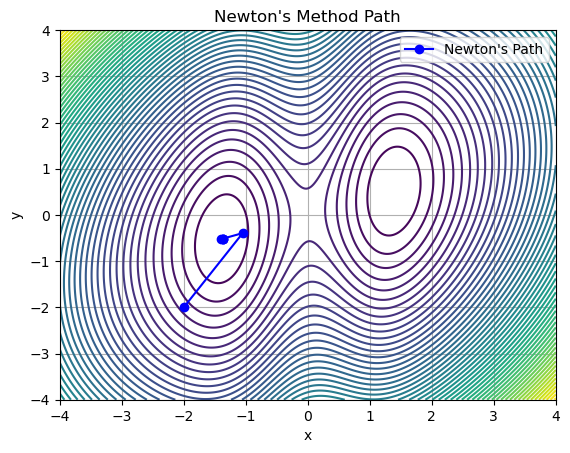

In [6]:
def hessian2(f, x, h=1e-5):
    """
    Approximate the Hessian matrix of f at x using central differences.
    """
    x = np.asarray(x, dtype=float)
    n = x.size
    hess = np.zeros((n, n))
    # Vectorized Hessian approximation using central differences
    idx = np.arange(n)
    e = np.eye(n)
    x_pp = x + h * e[:, None] + h * e[None, :]
    x_pm = x + h * e[:, None] - h * e[None, :]
    x_mp = x - h * e[:, None] + h * e[None, :]
    x_mm = x - h * e[:, None] - h * e[None, :]
    # Evaluate f at all required points
    f_pp = np.array([[f(x_pp[i, j]) for j in range(n)] for i in range(n)])
    f_pm = np.array([[f(x_pm[i, j]) for j in range(n)] for i in range(n)])
    f_mp = np.array([[f(x_mp[i, j]) for j in range(n)] for i in range(n)])
    f_mm = np.array([[f(x_mm[i, j]) for j in range(n)] for i in range(n)])
    hess = (f_pp - f_pm - f_mp + f_mm) / (4 * h**2)
    return hess

def derivative2(f, x, h=1e-5):
    """
    Approximate the gradient of f at x using central differences (vectorized).
    """
    x = np.asarray(x, dtype=float)
    n = x.size
    e = np.eye(n)
    f_ph = np.array([f(x + h * e[i]) for i in range(n)])
    f_mh = np.array([f(x - h * e[i]) for i in range(n)])
    grad = (f_ph - f_mh) / (2 * h)
    return grad

def newton(f, x0, tol=1e-6, N=100):
    """
    Newton's method for multivariate optimization.
    """
    x_now = np.array(x0, dtype=float)
    x_hist = [x_now.copy()]
    for i in range(N):
        grad = derivative2(f, x_now)
        hess = hessian2(f, x_now)
        try:
            step = np.linalg.solve(hess, grad)
        except np.linalg.LinAlgError:
            # Hessian is singular, fallback to gradient step
            step = grad
        x_next = x_now - step
        x_hist.append(x_next.copy())
        if np.linalg.norm(x_next - x_now) < tol:
            break
        x_now = x_next
    return np.array(x_hist), f(x_now)

# Run Newton's method and plot the path on the contour
z = f2([x, y])
x0, y0 = -2, -2
x_hist_newton, f_min_newton = newton(f2, [x0, y0])
plt.contour(x, y, z, levels=levels)
plt.plot(x_hist_newton[:, 0], x_hist_newton[:, 1], marker='o', color='blue', label="Newton's Path")
plt.title("Newton's Method Path")
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.grid()
plt.show()

## 13.2 From Newton to Quasi-Newton BFGS
Quasi-Newton methods are iterative optimization algorithms that aim to achieve the fast convergence of Newton's method without the computational burden of calculating and inverting the exact Hessian matrix at every step. Instead, they build up an approximation to the Hessian (or its inverse) using only gradient evaluations.

The key idea is to update the Hessian approximation at each iteration based on the observed changes in gradients and positions. This is typically done using rank-one or rank-two updates, ensuring that the new approximation satisfies the so-called secant equation:

$$
B_{k+1} s_k = y_k
$$

where $B_{k+1}$ is the updated Hessian approximation, $s_k = x_{k+1} - x_k$ is the step taken, and $y_k = \nabla f(x_{k+1}) - \nabla f(x_k)$ is the change in gradient.


### The BFGS Update Formula

One of the most widely used Quasi-Newton algorithms is the BFGS (Broyden–Fletcher–Goldfarb–Shanno) method. BFGS maintains a positive-definite approximation to the inverse Hessian, updating it efficiently at each step. This allows for rapid convergence similar to Newton's method, but with only first-order information.

It updates an approximation $H_k$ to the inverse Hessian matrix at each iteration using only gradient information. The update is designed to ensure symmetry and positive-definiteness, which are crucial for stable and efficient optimization.

Given:  
$$
s_k = x_{k+1} - x_k
$$

$$
y_k = \nabla f(x_{k+1}) - \nabla f(x_k)
$$


The BFGS update is:

$$
H_{k+1} = \left( I - \frac{s_k y_k^\top}{y_k^\top s_k} \right) H_k \left( I - \frac{y_k s_k^\top}{y_k^\top s_k} \right) + \frac{s_k s_k^\top}{y_k^\top s_k}
$$

**Key properties:**  
- The update uses only first-order information (gradients).  
- $H_{k+1}$ remains symmetric and positive-definite if $H_k$ is, provided $y_k^\top s_k > 0$.  
- The formula ensures the secant equation $H_{k+1} y_k = s_k$ is satisfied.

**Intuition:**  
- The first term "corrects" the previous Hessian approximation to account for new curvature information.
- The second term adds curvature in the direction of the most recent step.

In practice, BFGS is highly effective and is the default algorithm in many optimization libraries (such as `scipy.optimize.minimize` with `method='BFGS'`).

Quasi-Newton methods are especially powerful for large-scale problems where computing the full Hessian is impractical. They are the default choice in many scientific and machine learning optimization libraries due to their robustness and efficiency.


BFGS minimum: 1.309622 at [-1.37484528 -0.51556698]
Scipy BFGS minimum: 1.309622 at [-1.37484564 -0.51556669]


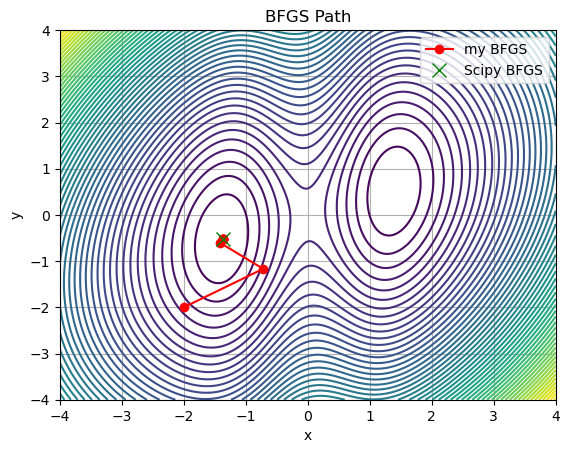

In [15]:
from scipy.optimize import minimize_scalar

# BFGS minimization
def bfgs_update(H, s, y):
    rho = 1.0 / (y @ s)
    I = np.eye(len(s))
    H_new = (I - rho * np.outer(s, y)) @ H @ (I - rho * np.outer(y, s)) + rho * np.outer(s, s)
    return H_new

def bfgs_minimize(f, x0, tol=1e-6, max_iter=1000):
    x = np.array(x0, dtype=float)
    n = len(x)
    H = np.eye(n)  # Initial Hessian approximation
    x_hist = [x.copy()]
    
    for i in range(max_iter):
        grad = derivative2(f, x)
        p = -H @ grad  # Search direction
        
        # Line search to find optimal step size
        # Backtracking line search to avoid overshoot
        alpha = 1.0
        c = 1e-4
        rho = 0.5
        while f(x + alpha * p) > f(x) + c * alpha * grad @ p:
            alpha *= rho
        
        s = alpha * p
        x_new = x + s
        x_hist.append(x_new.copy())
        
        if np.linalg.norm(s) < tol:
            break
        
        y = derivative2(f, x_new) - grad
        H = bfgs_update(H, s, y)
        x = x_new
    
    return np.array(x_hist), f(x)


# Run BFGS minimization
x_hist_bfgs, f_min_bfgs = bfgs_minimize(f2, [x0, y0])
print(f'BFGS minimum: {f_min_bfgs:.6f} at {x_hist_bfgs[-1]}')

# Run scipy's BFGS for comparison
from scipy.optimize import minimize
res = minimize(f2, [x0, y0], method='BFGS')#, jac=derivative2)
print(f'Scipy BFGS minimum: {res.fun:.6f} at {res.x}')

# Plot BFGS path on contour
plt.contour(x, y, z, levels=levels)
plt.plot(x_hist_bfgs[:, 0], x_hist_bfgs[:, 1], marker='o', color='red', label='my BFGS')
plt.plot(res.x[0], res.x[1], 'gx', markersize=10, label='Scipy BFGS')
plt.title('BFGS Path')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.grid()
plt.show()


## 13.3 L-BFGS

BFGS is a great advance. However, it is still problematic in some cases. In particular, when there are many variables, the Hessian requires a large $n \times n$ matrix for storage. To address this issue, L-BFGS (Limited-memory BFGS) is a popular variant of the BFGS quasi-Newton optimization algorithm, specifically designed for large-scale problems where storing and updating the full Hessian or its inverse is impractical due to memory constraints. With some smart design, L-BFGS achieves performance close to full BFGS in terms of convergence speed and robustness, making it the default choice for high-dimensional optimization in machine learning and scientific computing.

### How L-BFGS Works

1. **Store Recent Updates:**  
     At each iteration, store the most recent $m$ pairs of $(s_k, y_k)$, where  
     $s_k = x_{k+1} - x_k$ (step taken)  
     $y_k = \nabla f(x_{k+1}) - \nabla f(x_k)$ (change in gradient)

2. **Compute Search Direction:**  
    Use the two-loop recursion to compute the search direction $p_k = -H_k \nabla f(x_k)$ without explicitly forming $H_k$.  
    This recursion efficiently applies the inverse Hessian approximation to the gradient by using only the stored $(s_k, y_k)$ pairs from recent iterations. As a result, L-BFGS can approximate the Newton direction with much lower memory and computational cost, making it suitable for high-dimensional problems.

    The two-loop recursion computes $p_k$ as follows:

    2.1 **Initialization:**  
        Set $q = \nabla f(x_k)$.

    2.2 **First loop (backwards):**  
        For $i = k-1, k-2, ..., k-m$ (most recent $m$ updates):  
        &nbsp;&nbsp;&nbsp;&nbsp;$\alpha_i = \frac{s_i^\top q}{y_i^\top s_i}$  
        &nbsp;&nbsp;&nbsp;&nbsp;$q = q - \alpha_i y_i$

    2.3 **Apply initial Hessian approximation:**  
        Set $r = H_k^0 q$, where $H_k^0$ is typically a scalar multiple of the identity matrix (e.g., $H_k^0 = \frac{s_{k-1}^\top y_{k-1}}{y_{k-1}^\top y_{k-1}} I$).

    2.4 **Second loop (forwards):**  
        For $i = k-m, ..., k-2, k-1$:  
        &nbsp;&nbsp;&nbsp;&nbsp;$\beta_i = \frac{y_i^\top r}{y_i^\top s_i}$  
        &nbsp;&nbsp;&nbsp;&nbsp;$r = r + s_i (\alpha_i - \beta_i)$

    2.5 **Result:**  
        The search direction is $p_k = -r$.

    This procedure allows L-BFGS to efficiently approximate the Newton step using only $O(mn)$ memory and computation, where $m$ is the number of stored pairs and $n$ is the number of variables.

3. **Update:**  
     Move along $p_k$ using a line search, update $x_{k+1}$, and repeat.

### In Practice

L-BFGS is implemented in many optimization libraries, such as `scipy.optimize.minimize` with `method='L-BFGS-B'`, which also supports bound constraints.

---

**Summary:**  
L-BFGS brings the power of quasi-Newton methods to large-scale problems by using a limited memory approach, making it both efficient and scalable.